# Guiding questions

In Columbia, for every field, what has race/ethnicity representation looked like in the last twenty years?

In [127]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first convert the GSS export, a table representation of a nested tree, into a nested dictionary.

In [128]:
# Read in CSV
df = pd.read_csv(
    '../data/GSS_Export_Broad_RaceandEthnicity.csv', 
    header=4, # start table from 4th row of data
    skipfooter=4, # ignore last 4 lines of data (footer)
    engine='python', # default pandas engine does not support skipfooter
    index_col=False, # don't use first column (year) as dataframe index
)

# Rename columns for better readability
df.columns = ['Year', 'Institution Name', 'Broad Fields', 'Race and Ethnicity', 'Count']

# Remove Institution Name column (we know it's all Columbia)
df.drop('Institution Name', axis=1, inplace=True)

df['Count'] = df['Count'].str.replace(',', '') # remove all thousands-commas
df = df.astype({ 'Count': int }) # Convert column "Count" to integers

df.head()

,Year,Broad Fields,Race and Ethnicity,Count
0,2016,Total for selected values,Total for selected values,6498
1,2016,Total for selected values,Total for selected values,6498
2,2016,Biological sciences,Total for selected values,790
3,2016,Biological sciences,Ethnicity and race unknown or not stated,12
4,2016,Biological sciences,"Foreign nationals holding temporary visas, reg...",235


In [129]:
# Format: { year: { field: { race_ethnicity: count } } }
counts = defaultdict(lambda: defaultdict(dict))

# loop through all rows in dataframe
for _, row in df.iterrows():
    year = row['Year']
    field = row['Broad Fields']
    race_ethnicity = row['Race and Ethnicity']
    count = row['Count']
    counts[year][field][race_ethnicity] = count

In [130]:
years = [year for year in range(1994, 2017)]

fields = list(df['Broad Fields'].unique())

race_ethnicities = list(df['Race and Ethnicity'].unique())
race_ethnicities.remove('Total for selected values')

Let's now do some exploratory analysis on racial/ethnic diversity in every field.

In [110]:
def stack_proportions(ax, field, legend=False):
    proportions = {r: [] for r in race_ethnicities}
    
    for year in years:
        field_counts = counts[year][field]
        total = field_counts.get('Total for selected values', None)
        for r in race_ethnicities:
            if total is None:
                proportions[r].append(0)
            else:
                proportions[r].append(field_counts.get(r, 0) / total)

    stacks_items = proportions.items()
    labels, stacks = zip(*stacks_items)
    ax.stackplot(years, stacks, labels=labels)
    ax.set_title(field)
    
    if legend:
        ax.legend()

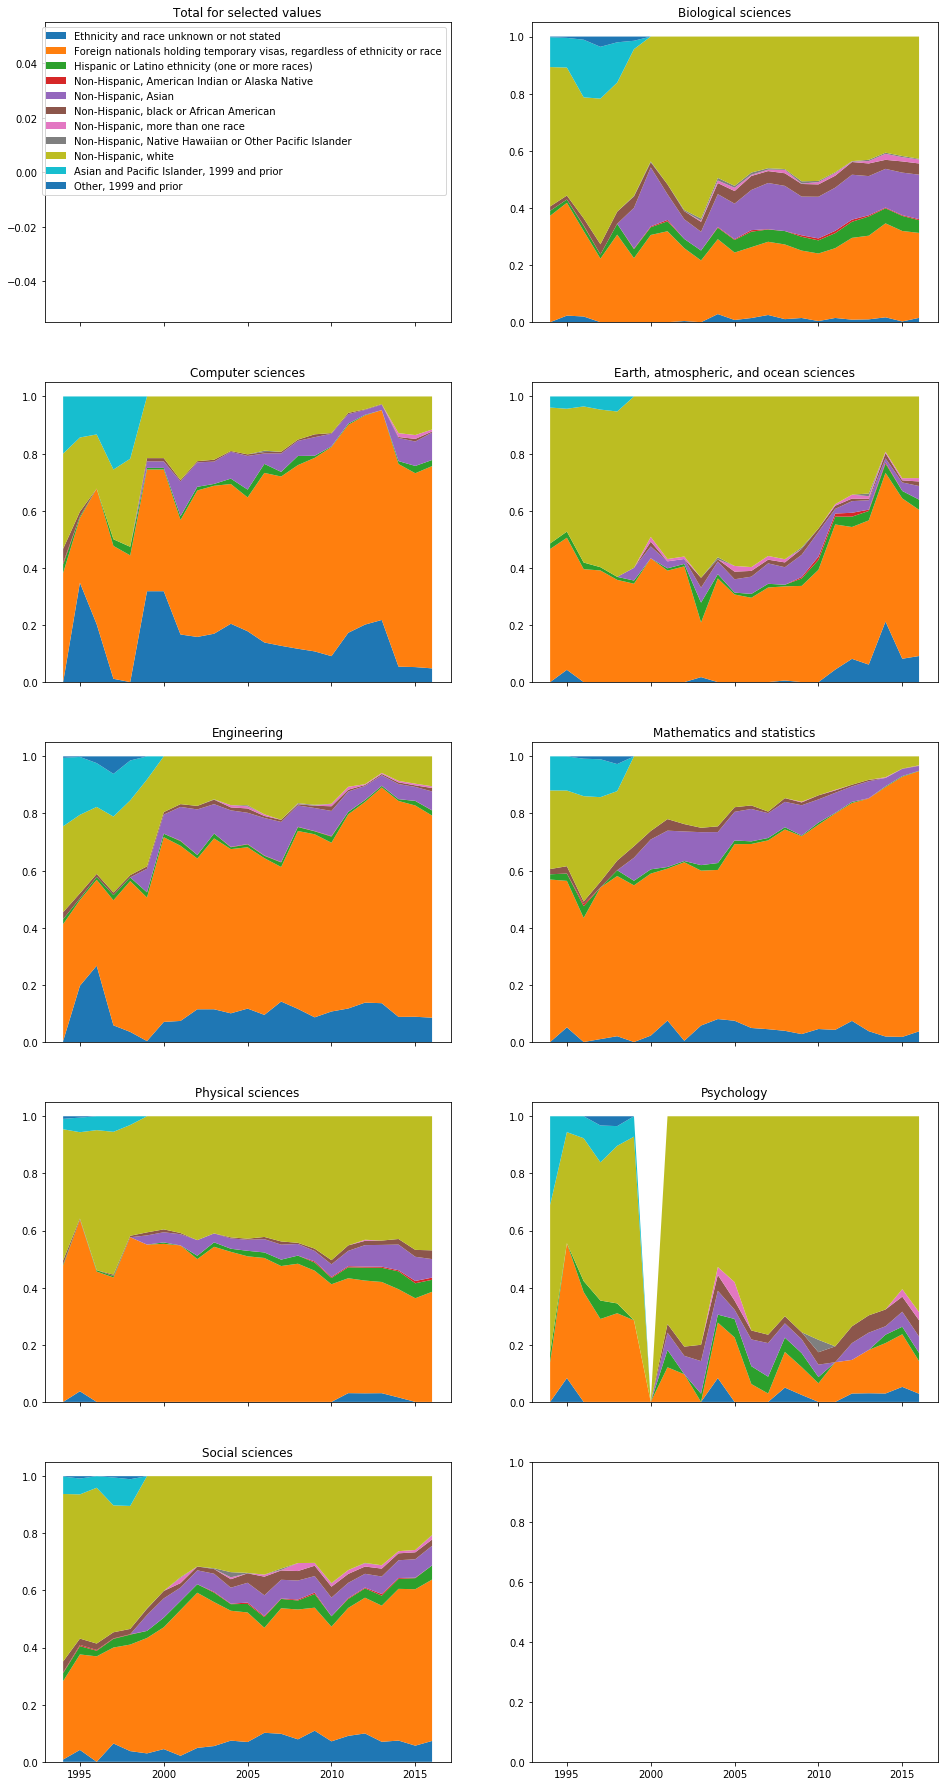

In [126]:
incompleteFields = ['Clinical medicine', 'Neurobiology and neuroscience', 'Other health']
completeFields = [f for f in fields if f not in incompleteFields]

fig, ax = plt.subplots(5, 2, sharex=True, figsize=(16, 32))
for index, field in enumerate(completeFields):
    stack_proportions(ax[index // 2, index % 2], field, legend=(index == 0))

# Findings